Calculate Mbar for distance measurements.
17 Dec 2022, J. Jensen
Lightly tested using only a single galaxy and wavelength

In [1]:
import sys, os
 
# path of the pysbf folder
# sys.path.insert(0, os.getcwd()+"/../../")
 
pysbf_path = "/home/sbf/"

# galaxy_root is where the WFC3/IR data are located; PS_root is where the PanSTARRS g,z data are located.
galaxy_root = '/Users/Joe/data/wfc3-16262/'
PS_root = '/Users/Joe/data/wfc3-16262/PS/'

sys.path.insert(0, pysbf_path)
from pysbf import *
 
configFolder = pysbf_path + "pysbf/config/sextractor/"

In [3]:
# Galaxy set up
name = "u12517"
mbarcolor = "F110W"  # F110W or F160W
ext_110 = 0.114
ext_160 = 0.0

In [4]:
# Region inclusion criteria
minsnr = 5   # minimum Pf/P1 SBF S/N
maxGCpeakdiff = 0.5  # mag Peak GCLF - cutoff mag < 0.5
minfrac = 0.5    # good pixels > 50%
mingalsky = 0.5  # gal/sky > 0.5
maxPrP0 = 0.1  # Pr/P0 < 0.1
maxmbarsig = 0.2  # maximum mag error on mbar
mingz = 1.2  # minimum g-z for the calibration
minjh = 0.22  # minimum J-H (AB) for calibration

In [ ]:
# data file -> look up table
# coming from the paper

In [5]:
# Calibration data (refs: Jensen+2015, Cantiello+2019, Jensen+2021)
# This should probably be in a config file.
# Common values used for all galaxies

mbarcolor = "F110W"  # F110W or F160W
color = "PS"  # PS, SDSS, DECam, ACS, 2MASS, WFC3IR
calibration = "linear"  # linear, quadratic, group, individual; linear default
calibrationwavelength = "gz"  # gz or jh

ext_sig = 0.1  # this is somewhat arbitrary, but we have been using it successfully in past years.
Prsig = 0.25  # in the past we used Pr uncertainty as 0.25*Pr
# /P0 + diff (SE-dophot), but we don't compute the latter. 
# dpr(k) = pr(k) * amax1(Prsig, 2*(emcut(k)-emexp(k)))

# Latest LMC distance modulus 18.477 (ref: Pietrzyński et al. 2019)
LMC_correction = -0.023

if mbarcolor == "F160W" and calibrationwavelength == "gz" and calibration == "linear":
    Mbar_slope = 2.13
    Mbar_zp = -3.640
    Mbar_rms = 0.114
    Mbar_offset = -1.4
    ext = ext_160

elif mbarcolor == "F160W" and calibrationwavelength == "jh" and calibration == "linear":
    Mbar_slope = 7.1
    Mbar_zp = -3.668
    Mbar_rms = 0.121
    Mbar_offset = -0.27
    ext = ext_160
  
elif mbarcolor == "F110W" and calibrationwavelength == "jh" and calibration == "linear":
    Mbar_slope = 6.7
    Mbar_zp = -2.914
    Mbar_rms = 0.092
    Mbar_offset = -0.27
    ext = ext_110

# default to PanSTARRS g-z
elif mbarcolor == "F110W" and calibrationwavelength == "gz" and calibration == "linear":
    Mbar_slope = 2.16
    Mbar_zp = -2.887
    Mbar_rms = 0.06
    Mbar_offset=-1.4
    ext = ext_110
    
else:
    exit("Calibration not found.")
    
# Conversion factors for colors (ref: Jensen+2021)
if color=="SDSS":
    acsgz_slope = 0.01
    acsgz_zp = -0.01
    acsgz_rmsc0 = 0.019
    acsgz_rmsc1 = 0.04
    acsgz_rmsc2 = 0.098
    acsgz_rmsc5 = 0.1 # undefined for c5
elif color=="DECam":  # not yet measured
    acsgz_slope = 0.
    acsgz_zp = 0.
    acsgz_rmsc0 = 0.0
    acsgz_rmsc1 = 0.0
    acsgz_rmsc2 = 0.0
    acsgz_rmsc5 = 0.0 
elif color=="ACS":  # by definition
    acsgz_slope = 0.
    acsgz_zp = 0.
    acsgz_rmsc0 = 0.01  # nominal color uncertainty assumption
    acsgz_rmsc1 = 0.015
    acsgz_rmsc2 = 0.015
    acsgz_rmsc5 = 0.02
else:  # These are the default PanSTARRS values
    acsgz_slope = 0.092
    acsgz_zp = -0.009
    acsgz_rmsc0 = 0.016
    acsgz_rmsc1 = 0.016
    acsgz_rmsc2 = 0.018
    acsgz_rmsc5 = 0.02 # undefined for c5

# WFC3/IR J-H = 2MASS J-H * slope + zp
if color == "WFC3IR":  # by definition
    wfc3jh_slope = 0
    wfc3jh_zp = 0
    wfc3jh_rmsc0 = 0.01  # nominal color error assumption
    wfc3jh_rmsc1 = 0.02
    wfc3jh_rmsc2 = 0.05
    wfc3jh_rmsc5 = 0.1
else:   # default to 2MASS for J-H
    wfc3jh_slope = 0.158
    wfc3jh_zp = 0.065
    wfc3jh_rmsc0 = 0.0156
    wfc3jh_rmsc1 = 0.0244
    wfc3jh_rmsc2 = 0.0579
    wfc3jh_rmsc5 = 0.114 

# Future upgrades: 
# include more color transformation for SkyMapper and DECam
# add the quadratic calibration for the galaxies with g-z<1.2. 
# Right now they are just excluded.
# I would have to move this calibration block below the part where galaxy color is read.

In [6]:
# Read galaxy PanSTARRS g-z color data from json file
# if color == "PS":
#      read gz values from json file
# elif color == "2MASS":
#      read jh values from somewhere else...etc.

if color == "PS":
# This is just an example/test case UGC12517 (of course)
    gzc0 = 1.334   # outputs of the color notebook
    gzc1 = 1.333
    gzc2 = 1.338
    gzc5 = 1.34
    ext_g = 0.592
    ext_z = 0.247
    gzc0sig = math.sqrt((ext_sig*(ext_g-ext_z))**2 + acsgz_rmsc0**2)  # uncertainties
    gzc1sig = math.sqrt((ext_sig*(ext_g-ext_z))**2 + acsgz_rmsc1**2)
    gzc2sig = math.sqrt((ext_sig*(ext_g-ext_z))**2 + acsgz_rmsc2**2)
    gzc5sig = math.sqrt((ext_sig*(ext_g-ext_z))**2 + acsgz_rmsc5**2)

if color=="2MASS":
    # Read J-H color data from somewhere
    jhc0 = 0.72
    jhc1 = 0.72
    jhc2 = 0.72
    jhc5 = 0.72
    ext_j = 0.0
    ext_h = 0.0
    jhc0sig = math.sqrt((ext_sig*(ext_h-ext_h))**2 + wfc3jh_rmsc0**2)
    jhc1sig = math.sqrt((ext_sig*(ext_h-ext_h))**2 + wfc3jh_rmsc1**2)
    jhc2sig = math.sqrt((ext_sig*(ext_h-ext_h))**2 + wfc3jh_rmsc2**2)
    jhc5sig = math.sqrt((ext_sig*(ext_h-ext_h))**2 + wfc3jh_rmsc5**2)

NameError: name 'math' is not defined

In [7]:
# Compute Mbar
# This works for g-z but not tested for J-H yet.

# claculating Mbar for the specific color, no SBF analysis data yet

if color=="2MASS": # Use J-H if necessary; we don't have other options yet.
    # note that 2MASS photometry is in Vega mags, the -0.4919 converts to AB
    wfc3jhc0 = (jhc0 - 0.4919) * (1+wfc3jh_slope) + wfc3jh_zp
    wfc3jhc1 = (jhc1 - 0.4919) * (1+wfc3jh_slope) + wfc3jh_zp
    wfc3jhc2 = (jhc2 - 0.4919) * (1+wfc3jh_slope) + wfc3jh_zp
    wfc3jhc5 = (jhc5 - 0.4919) * (1+wfc3jh_slope) + wfc3jh_zp
    
    Mbarc0 = Mbar_zp + ((wfc3jhc0+Mbar_offset) * Mbar_slope) - LMC_correction
    Mbarc1 = Mbar_zp + ((wfc3jhc1+Mbar_offset) * Mbar_slope) - LMC_correction
    Mbarc2 = Mbar_zp + ((wfc3jhc2+Mbar_offset) * Mbar_slope) - LMC_correction
    Mbarc5 = Mbar_zp + ((wfc3jhc5+Mbar_offset) * Mbar_slope) - LMC_correction

    Mbarsigc0 = math.sqrt(Mbar_rms**2 + (Mbar_slope*jhc0sig)**2)
    Mbarsigc1 = math.sqrt(Mbar_rms**2 + (Mbar_slope*jhc1sig)**2)
    Mbarsigc2 = math.sqrt(Mbar_rms**2 + (Mbar_slope*jhc2sig)**2)
    Mbarsigc5 = math.sqrt(Mbar_rms**2 + (Mbar_slope*jhc5sig)**2)
    print(wfc3jhc1, jhc1sig, Mbarc1, Mbarsigc1)
    
elif calibrationwavelength == "gz": # g-z is default
    acs_gzc0 = gzc0 * (1+acsgz_slope) + acsgz_zp
    acs_gzc1 = gzc1 * (1+acsgz_slope) + acsgz_zp
    acs_gzc2 = gzc2 * (1+acsgz_slope) + acsgz_zp
    acs_gzc5 = gzc5 * (1+acsgz_slope) + acsgz_zp

    Mbarc0 = Mbar_zp + ((acs_gzc0+Mbar_offset) * Mbar_slope) - LMC_correction
    Mbarc1 = Mbar_zp + ((acs_gzc1+Mbar_offset) * Mbar_slope) - LMC_correction
    Mbarc2 = Mbar_zp + ((acs_gzc2+Mbar_offset) * Mbar_slope) - LMC_correction
    Mbarc5 = Mbar_zp + ((acs_gzc5+Mbar_offset) * Mbar_slope) - LMC_correction

    Mbarsigc0 = math.sqrt(Mbar_rms**2 + (Mbar_slope*gzc0sig)**2)
    Mbarsigc1 = math.sqrt(Mbar_rms**2 + (Mbar_slope*gzc1sig)**2)
    Mbarsigc2 = math.sqrt(Mbar_rms**2 + (Mbar_slope*gzc2sig)**2)
    Mbarsigc5 = math.sqrt(Mbar_rms**2 + (Mbar_slope*gzc5sig)**2)

    print("c0: (g-z) =","{:.4}".format(acs_gzc0),"+/-","{:.3}".format(gzc0sig),"  Mbar =","{:.4}".format(Mbarc0),"+/-","{:.3}".format(Mbarsigc0))
    print("c1: (g-z) =","{:.4}".format(acs_gzc1),"+/-","{:.3}".format(gzc1sig),"  Mbar =","{:.4}".format(Mbarc1),"+/-","{:.3}".format(Mbarsigc1))
    print("c2: (g-z) =","{:.4}".format(acs_gzc2),"+/-","{:.3}".format(gzc2sig),"  Mbar =","{:.4}".format(Mbarc2),"+/-","{:.3}".format(Mbarsigc2))
    print("c5: (g-z) =","{:.4}".format(acs_gzc5),"+/-","{:.3}".format(gzc5sig),"  Mbar =","{:.4}".format(Mbarc5),"+/-","{:.3}".format(Mbarsigc5))
    

NameError: name 'math' is not defined

In [ ]:
# Get SBF data from bestfluc output in json format--or better yet, just add all of this to bestfluc!
# Bestfluc already has all this information, but it lacks the calibration definitions and colors.

# These values for U12517 are for testing.
ext_110 = 0.164
sky = 3250      # background, eliprof notebook
rc0 = 6.4       # get_sbf results <r> =  99.5 
rc1 = 12.7      # the average radius of each anulus
rc2 = 25.2
rc5 = 50
fracc0 = 0.9    # comes from get_sbf - number of unmasked pixels in an anulus  comupted by bestfluc (sliver)
fracc1 = 0.89   # for now I assume it is == 1 
fracc2 = 0.85
fracc5 = 0.78
galskyc0 = 16.4  # ratio of the gal brightness to background
galskyc1 = 5.1   
galskyc2 = 1.43
galskyc5 = 0.335
PrP0c0 = 0.07    # ratio or Pr/P0
PrP0c1 = 0.068
PrP0c2 = 0.097
PrP0c5 = 0.213
snrc0 = 9.65    # (P0-Pr)/P1
snrc1 = 10.3
snrc2 = 8.6
snrc5 = 3.6
GCpeak = 25.0         # mag of the GCLF peak --> likenew notebook
GCpeakdist = 70       # distance that used to compute the GCLF peak
GCpeakdiffc0 = 0.52   # GCLF peak - completness magnitude : bad if it's a big number (>~0.5 mg)
GCpeakdiffc1 = 0.12
GCpeakdiffc2 = -0.16
GCpeakdiffc5 = -0.34
mbarc0 = 31.64      # fluctation magnitudes  <- get_sbf
mbarc1 = 31.59
mbarc2 = 31.51
mbarc5 = 31.46
P0sigc0 = 0.02     # fit uncertainty on P0
P0sigc1 = 0.02
P0sigc2 = 0.03
P0sigc5 = 0.07
skysigc0 = 0.02    # Monte carlo  -> sigma due to sky uncertainty
skysigc1 = 0.03
skysigc2 = 0.05
skysigc5 = 0.10
psfsigc0 = 0.015
psfsigc1 = 0.015
psfsigc2 = 0.015
psfsigc5 = 0.015
Prsigc0 = Prsig * PrP0c0 
Prsigc1 = Prsig * PrP0c1
Prsigc2 = Prsig * PrP0c2
Prsigc5 = Prsig * PrP0c5

# combine observational uncertainties in quadrature
mbarsigc0 = math.sqrt(P0sigc0**2 + skysigc0**2 + psfsigc0**2 + Prsigc0**2)
mbarsigc1 = math.sqrt(P0sigc1**2 + skysigc1**2 + psfsigc1**2 + Prsigc1**2)
mbarsigc2 = math.sqrt(P0sigc2**2 + skysigc2**2 + psfsigc2**2 + Prsigc2**2)
mbarsigc5 = math.sqrt(P0sigc5**2 + skysigc5**2 + psfsigc5**2 + Prsigc5**2)
    
print("c0: mbar =", "{:.5}".format(mbarc0)," +/-","{:.2}".format(mbarsigc0))
print("c1: mbar =", "{:.5}".format(mbarc1)," +/-","{:.2}".format(mbarsigc1))
print("c2: mbar =", "{:.5}".format(mbarc2)," +/-","{:.2}".format(mbarsigc2))
print("c5: mbar =", "{:.5}".format(mbarc5)," +/-","{:.2}".format(mbarsigc5))


In [ ]:
# conditions to reject result

In [8]:
# Identify good regions to use
print("Min of (P0-Pr)/P1 = ",minsnr)
print("Max GCLF peak - limiting mag = ",maxGCpeakdiff)
print("Min fraction unmasked pixels = ", minfrac)
print("Min galaxy/sky =", mingalsky)
print("Max Pr/P0 = ", maxPrP0)
print("Max mbar uncertainty = ", maxmbarsig)
print("Min (g-z) =",mingz)
print("Min (J-H) =",minjh)
print("")
usec0=False; usec1=False; usec2=False; usec5=False

if snrc0>minsnr and GCpeakdiffc0<maxGCpeakdiff and fracc0>minfrac and galskyc0>mingalsky and PrP0c0<maxPrP0 and mbarsigc0<maxmbarsig and acs_gzc0>mingz:
    usec0=True
    print("Including c0")
if snrc1>minsnr and GCpeakdiffc1<maxGCpeakdiff and fracc1>minfrac and galskyc1>mingalsky and PrP0c1<maxPrP0 and mbarsigc1<maxmbarsig and acs_gzc1>mingz:
    usec1=True
    print("Including c1")
if snrc2>minsnr and GCpeakdiffc2<maxGCpeakdiff and fracc2>minfrac and galskyc2>mingalsky and PrP0c2<maxPrP0 and mbarsigc2<maxmbarsig and acs_gzc2>mingz:
    usec2=True
    print("Including c2")
if snrc5>minsnr and GCpeakdiffc5<maxGCpeakdiff and fracc5>minfrac and galskyc5>mingalsky and PrP0c5<maxPrP0 and mbarsigc5<maxmbarsig and acs_gzc5>mingz:
    usec5=True
    print("Including c5")
   

Min of (P0-Pr)/P1 =  5
Max GCLF peak - limiting mag =  0.5
Min fraction unmasked pixels =  0.5
Min galaxy/sky = 0.5
Max Pr/P0 =  0.1
Max mbar uncertainty =  0.2
Min (g-z) = 1.2
Min (J-H) = 0.22



NameError: name 'snrc0' is not defined

In [ ]:
# Calculate distances and uncertainties

distmodc0 = (mbarc0 - Mbarc0)
distmodc1 = (mbarc1 - Mbarc1)
distmodc2 = (mbarc2 - Mbarc2)
distmodc5 = (mbarc5 - Mbarc5)

distmodsigc0 = math.sqrt(mbarsigc0**2 + Mbarsigc0**2)
distmodsigc1 = math.sqrt(mbarsigc1**2 + Mbarsigc1**2)
distmodsigc2 = math.sqrt(mbarsigc2**2 + Mbarsigc2**2)
distmodsigc5 = math.sqrt(mbarsigc5**2 + Mbarsigc5**2)

# these are calculated here for reference but are not used later.
distc0 = 10**(distmodc0/5 - 5)
distc1 = 10**(distmodc1/5 - 5)
distc2 = 10**(distmodc2/5 - 5)
distc5 = 10**(distmodc5/5 - 5)

distsigc0 = (10**((distmodc0+distmodsigc0)/5 - 5) - 10**((distmodc0-distmodsigc0)/5 - 5)) / 2
distsigc1 = (10**((distmodc1+distmodsigc1)/5 - 5) - 10**((distmodc1-distmodsigc1)/5 - 5)) / 2
distsigc2 = (10**((distmodc2+distmodsigc2)/5 - 5) - 10**((distmodc2-distmodsigc2)/5 - 5)) / 2
distsigc5 = (10**((distmodc5+distmodsigc5)/5 - 5) - 10**((distmodc5-distmodsigc5)/5 - 5)) / 2

n=0
if usec0:
    n=n+1
    print("c0: (m-M) =", "{:.5}".format(distmodc0)," +/-","{:.3}".format(distmodsigc0),"  d =","{:.3}".format(distc0)," +/-","{:.2}".format(distsigc0)," Mpc")
if usec1:
    n=n+1
    print("c1: (m-M) =", "{:.5}".format(distmodc1)," +/-","{:.3}".format(distmodsigc1),"  d =","{:.3}".format(distc1)," +/-","{:.2}".format(distsigc1)," Mpc")
if usec2:
    n=n+1
    print("c2: (m-M) =", "{:.5}".format(distmodc2)," +/-","{:.3}".format(distmodsigc2),"  d =","{:.3}".format(distc2)," +/-","{:.2}".format(distsigc2)," Mpc")
if usec5:
    n=n+1
    print("c5: (m-M) =", "{:.5}".format(distmodc5)," +/-","{:.3}".format(distmodsigc5),"  d =","{:.3}".format(distc5)," +/-","{:.2}".format(distsigc5)," Mpc")

# write distances and uncertainties to the output file

In [9]:
# Weighted average distances for good annuli only

# Note that this section trashes the computed values for the excluded regions, so you need to rerun the code from the beginning.
if not usec0:
    distmodc0=0; distmodsigc0=1E9; mbarsigc0=1E9; Mbarsigc0=0
if not usec1:
    distmodc1=0; distmodsigc1=1E9; mbarsigc1=1E9; Mbarsigc1=0
if not usec2:
    distmodc2=0; distmodsigc2=1E9; mbarsigc2=1E9; Mbarsigc2=0
if not usec5:
    distmodc5=0; distmodsigc5=1E9; mbarsigc5=1E9; Mbarsigc5=0

# annular regions are treated as independent measurements for weighted average and uncertainties
distmodwtav = math.sqrt(distmodc0**2/distmodsigc0**2 + distmodc1**2/distmodsigc1**2 + distmodc2**2/distmodsigc2**2 + distmodc5**2/distmodsigc5**2) / math.sqrt(1/distmodsigc0**2 + 1/distmodsigc1**2 + 1/distmodsigc2**2 + 1/distmodsigc5**2)
mbarsigwtav = 1 / math.sqrt(1/mbarsigc0**2 + 1/mbarsigc1**2 + 1/mbarsigc2**2 + 1/mbarsigc5**2)

# Extintion uncertainty is not independent for annuli, it's systematic, so add it on
mbarsigwtav = (ext_sig * ext) + mbarsigwtav  # add systematic uncertainty from extinction to obs error

# Calibration Mbar uncertainties are not really independent for each region. Just average them.
Mbarsigwtav = (Mbarsigc0 + Mbarsigc1 + Mbarsigc2 + Mbarsigc5)/n


distmodsigwtav = math.sqrt(mbarsigwtav**2 + Mbarsigwtav**2)  # add obs and cal errors in quadrature

distwtav = 10**(distmodwtav/5 - 5)
# Distance uncertainties are not symmetrical in distance. I just average the + and - uncertaintes...
distsigwtavplus = 10**((distmodwtav+distmodsigwtav)/5 -5) - distwtav
distsigwtavminus = distwtav - 10**((distmodwtav-distmodsigwtav)/5 -5)
distsigwtav = (distsigwtavplus + distsigwtavminus) / 2

print("(m-M) =","{:.5}".format(distmodwtav),"+/-","{:.3}".format(distmodsigwtav))
print("d =","{:.3}".format(distwtav),"+/-","{:.2}".format(distsigwtav))
print("d =","{:.3}".format(distwtav),"+","{:.2}".format(distsigwtavplus),"-","{:.2}".format(distsigwtavminus))

# Write results to the output file.


NameError: name 'math' is not defined

In [ ]:
# more ./wfc3-16262/u11990/u11990doj.MBAR 
# the output ogf bestfluc

(array([0.295, 0.19 , 0.11 , 0.105, 0.085, 0.06 , 0.06 , 0.065, 0.03 ]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <BarContainer object of 9 artists>)

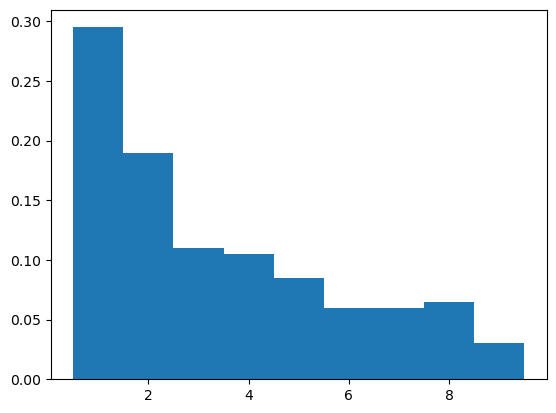

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

X0 = np.asarray([13])   # initial value; arbitrary
X = copy.deepcopy(X0)

growth_factor = 2.3   # arbitrary
for i in range(100):
    X0 = growth_factor * X0
    X = np.concatenate((X, X0))

X0 = np.asarray([18])   # initial value; arbitrary
growth_factor = 1.7   # arbitrary
for i in range(100):
    X0 = growth_factor * X0
    X = np.concatenate((X, X0))


left_digit = np.asarray([int(str(x)[0]) for x in X[1:]])
plt.hist(left_digit, bins=np.arange(0.5, 10.5, 1), density=True)

# Benford's Law holds true for a data set that grows exponentially

In [7]:
1+np.random.random()

1.6891303655663625

(array([0.25, 0.16, 0.1 , 0.12, 0.11, 0.1 , 0.04, 0.09, 0.03]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <BarContainer object of 9 artists>)

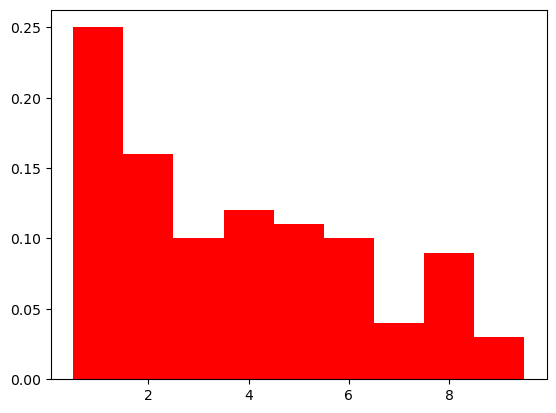

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

X = np.asarray([0])

for i in range(100):     # number of cities
    
    growth_factor = 2+np.random.random()   # arbitrary value for the city

    # arbitrary initial value; minimum number of ballots in a box
    X0 = growth_factor * np.random.randint(1, 30, size=1) 
    X1 = copy.deepcopy(X0)
    for j in range(100):   # possible number of ballots in a box
        X0 = growth_factor * X0
        X1 = np.concatenate((X1, X0))

    # choose one poissbility randomly
    X = np.concatenate((X, np.random.choice(X1, 1)))
    
left_digit = np.asarray([int(str(x)[0]) for x in X[1:]])
plt.hist(left_digit, bins=np.arange(0.5, 10.5, 1), density=True, color='red')

# Benford's Law holds true for a data set that grows exponentially